## SDA Project | Team 9

### Students:

Fennom Schalkwijk - 14619148 \
Kelt Paehlig - 14634716 \
Babet Wijsman -

For more info about the project, see the README.

This notebook contains the code for the analysis of the dataset (week 2-4). The notebook is divided into
sections, see the table of contents below.

### Table of Contents:

1. [Reformatting Data for Logistic Regression](#reformatting-data)  
   1.1 [Categorial data to numerical data](#categorial-to-numerical)  
   1.2 [Multiple categories](#multiple-categories)  
   1.3 [Normalisation of numerical values](#normalisation)  
   1.4 [Dropping consumption columns](#dropping-consumption)  
   1.5 [Correlation matrix](#correlation-matrix)  
   1.6 [Plots of healthy people against people with heart disease](#plots-healthy-unhealthy)
2. [Running a basic logistic regression model](#logistic-regression)  
   2.1 [Creating training and testing data](#testing-training-data)  
   2.2 [Running model](#running-model)  
   2.3 [Simulating coefficients](#simulating-coefficients)
3. [Principal Component Analysis](#pca)  
   3.1 [Finding amount of components needed](#amount-components)
4. [Cross Validation](#crossVal) \
   4.1 [Implementation for answering RQ 2](#comparing-models) \
   4.2 [Implementation for analysis arbitrary variable selection](#select-variables) \
   4.3 [Implementation for reversed selection of variables](#reversed-selection) \
   4.4 [Implementation for `Exercise` only](#exercise-implementation)

All the necesarry imports, add any new ones here and update `requirements.txt` by running `pip freeze > requirements.txt`.


In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import random
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from scipy.stats import multivariate_normal
import seaborn as sns
import os

Add folder for graphs of results


In [89]:
paths = ["../Graphs/results/", "../Graphs/dataset/"]

for path in paths:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print("Making path {path} failed")

Read the data


In [90]:
data = pd.read_csv("../Data/CVD_cleaned.csv")

In [91]:
display(data.head())

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


## Reformatting the data for logistic regression

<a id='reformatting-data'></a>

### Categorial data to numerical data

<a id='categorial-to-numerical'></a>

Before we are able to do any sort of analysis on the dataset, we need to ensure that the data has a format that we are able to do 'math' with. As an example, 'yes' or 'no' is not something we can do math with, so we have to convert this properly.


Reformat every yes and no to a binary 0 or 1. For sex, we will take male to be 1 and female to be 0. We also change the name to 'Sex_Male' to make this more clear.


In [92]:
data = (
    data.replace(
        {
            "Skin_Cancer": "Yes",
            "Other_Cancer": "Yes",
            "Heart_Disease": "Yes",
            "Depression": "Yes",
            "Smoking_History": "Yes",
            "Exercise": "Yes",
            "Sex": "Male",
            "Arthritis": "Yes",
        },
        1,
    )
    .replace(
        {
            "Skin_Cancer": "No",
            "Other_Cancer": "No",
            "Heart_Disease": "No",
            "Depression": "No",
            "Smoking_History": "No",
            "Exercise": "No",
            "Sex": "Female",
            "Arthritis": "No",
        },
        0,
    )
    .rename(columns={"Sex": "Sex_Male"})
)

As we can see, the data which first was 'yes' or 'no' now has a binary value.


In [93]:
data.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex_Male,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,0,0,0,0,0,No,1,0,70-74,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,0,1,0,0,0,Yes,0,0,70-74,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,1,0,0,0,0,Yes,0,0,60-64,163.0,88.45,33.47,0,4.0,12.0,3.0,16.0
3,Poor,Within the past year,1,1,0,0,0,Yes,0,1,75-79,180.0,93.44,28.73,0,0.0,30.0,30.0,8.0
4,Good,Within the past year,0,0,0,0,0,No,0,1,80+,191.0,88.45,24.37,1,0.0,8.0,4.0,0.0


### Multiple categories <a id='multiple-categories'></a>

There are a few columns which work with categries, such as age ranges or yes/no or "yes, ...". We will also have to somehow convert these into a format that we can work with.


In [94]:
print(data["Age_Category"].unique())

['70-74' '60-64' '75-79' '80+' '65-69' '50-54' '45-49' '18-24' '30-34'
 '55-59' '35-39' '40-44' '25-29']


In [95]:
print(data["Diabetes"].unique())

['No' 'Yes' 'No, pre-diabetes or borderline diabetes'
 'Yes, but female told only during pregnancy']


In [96]:
print(data["Checkup"].unique())

['Within the past 2 years' 'Within the past year' '5 or more years ago'
 'Within the past 5 years' 'Never']


In [97]:
print(data["General_Health"].unique())

['Poor' 'Very Good' 'Good' 'Fair' 'Excellent']


For the age range, we will take the value exactly in the middle of the range (average). For the 80+ range, we will take 85. For diabetes, we have grouped the different types of diabeted into one category, ending up with either yes or no. For the recent checkups, we split the group into the people that had a checkup in the last two years and the people that did not. The perceived health is split up into a group that says their health is good or better, and the group that says their health is fair or poor.


In [98]:
# Set age to numerical by taking the mean of the existing categories (ASSUMPTION: 80+ is estimated to 85)
age_mapping = {
    "18-24": 21.0,
    "25-29": 27.0,
    "30-34": 32.0,
    "35-39": 37.0,
    "40-44": 42.0,
    "45-49": 47.0,
    "50-54": 52.0,
    "55-59": 57.0,
    "60-64": 62.0,
    "65-69": 67.0,
    "70-74": 72.0,
    "75-79": 77.0,
    "80+": 85.0,
}

data["Age_Category"] = data["Age_Category"].map(age_mapping)
data = data.rename(columns={"Age_Category": "Age_Numeric"})

# Normalize age (done in such a way that we can interpret an increase in age as a 10 year increase over the average age)
data["Age_Numeric"] = (data["Age_Numeric"] - data["Age_Numeric"].mean()) / 10
data = data.rename(columns={"Age_Numeric": "Age_Normalised"})

# Diabetes, we group everyone that every had diabetes as diabetic, and the
# people who never had diabetes as non diabetic.
diabetes_binary = [0 if i == "No" else 1 for i in data["Diabetes"]]
data["Diabetes"] = diabetes_binary
data = data.rename(columns={"Diabetes": "Diabetic"})

# We split the checkup group into the people who has a checkup in the last two years
# and the people who did not.
checkup_binary = [
    1 if i == "Within the past year" or i == "Within the past 2 years" else 0
    for i in data["Checkup"]
]
data["Checkup"] = checkup_binary
data = data.rename(columns={"Checkup": "Recent_Checkup"})

# Perceived health is split into the group with good or better health
# and the group with fair or poor health.
health_binary = [0 if i == "Fair" or i == "Poor" else 1 for i in data["General_Health"]]
data["General_Health"] = health_binary
data = data.rename(columns={"General_Health": "Health_Good_or_Better"})

### Normalisation of numerical values <a id='normalisation'></a>

The numerical values in the dataset must be normalised in order to ensure we can focus on patterns and not on scale. We use a method so that we can interpret one-point deviations in the normalised data as deviations from the mean.

This is done for all the numerical columns in the dataset, where we normalise such that:
- A value of 1 in height is interpreted as a 10cm increase over the average height.
- A value of 1 in weight is interpreted as a 5kg increase over the average weight.
- A value of 1 in age is interpreted as a 10 year increase over the average age (this normalisation was already completed in the cell above).
- A value of 1 in BMI is interpreted as a 1 point increase over the average BMI.

In [99]:
# Normalise the height (done in such a way that we can interpret an increase in height as a 10 cm increase over the average height)
data["Height_(cm)"] = (data["Height_(cm)"] - data["Height_(cm)"].mean()) / 10
data = data.rename(columns={"Height_(cm)": "Height_norm"})

# Normalise the weight (done in such a way that we can interpret an increase in weight as a 5 kg increase over the average weight)
data["Weight_(kg)"] = (data["Weight_(kg)"] - data["Weight_(kg)"].mean()) / 5
data = data.rename(columns={"Weight_(kg)": "Weight_norm"})

# Normalise the bmi (done in such a way that we can interpret an increase in bmi as a 1 point increase over the average bmi)
data["BMI"] = data["BMI"] - data["BMI"].mean()
data = data.rename(columns={"BMI": "BMI_norm"})

data.head()

,Health_Good_or_Better,Recent_Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetic,Arthritis,Sex_Male,Age_Normalised,Height_norm,Weight_norm,BMI_norm,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,0,1,0,0,0,0,0,0,1,0,1.716472,-2.061525,-10.185731,-14.086211,1,0.0,30.0,16.0,12.0
1,1,1,0,1,0,0,0,1,0,0,1.716472,-0.561525,-1.295731,-0.336211,0,0.0,30.0,0.0,4.0
2,1,1,1,0,0,0,0,1,0,0,0.716472,-0.761525,0.972269,4.843789,0,4.0,12.0,3.0,16.0
3,0,1,1,1,0,0,0,1,0,1,2.216472,0.938475,1.970269,0.103789,0,0.0,30.0,30.0,8.0
4,1,1,0,0,0,0,0,0,0,1,3.016472,2.038475,0.972269,-4.256211,1,0.0,8.0,4.0,0.0


### Dropping consumption columns <a id='dropping-consumption'></a>

The author of the dataset has no information on the columns Alcohol_Consumption, Fruit_Consumption, Green_Vegetables_Consumption, FriedPotato_Consumption. From the survey it is possible that these columns are the frequency that someone consumes these items in a month but we can not be sure. Because of this, we are going to drop these columns.


In [100]:
data = data.drop(
    columns=[
        "Alcohol_Consumption",
        "Fruit_Consumption",
        "Green_Vegetables_Consumption",
        "FriedPotato_Consumption",
    ]
)
data.head()

,Health_Good_or_Better,Recent_Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetic,Arthritis,Sex_Male,Age_Normalised,Height_norm,Weight_norm,BMI_norm,Smoking_History
0,0,1,0,0,0,0,0,0,1,0,1.716472,-2.061525,-10.185731,-14.086211,1
1,1,1,0,1,0,0,0,1,0,0,1.716472,-0.561525,-1.295731,-0.336211,0
2,1,1,1,0,0,0,0,1,0,0,0.716472,-0.761525,0.972269,4.843789,0
3,0,1,1,1,0,0,0,1,0,1,2.216472,0.938475,1.970269,0.103789,0
4,1,1,0,0,0,0,0,0,0,1,3.016472,2.038475,0.972269,-4.256211,1


### Correlation matrix

<a id='correlation-matrix'></a>

Now that all the data is in a format that can be worked with, we can make a correlation matrix.


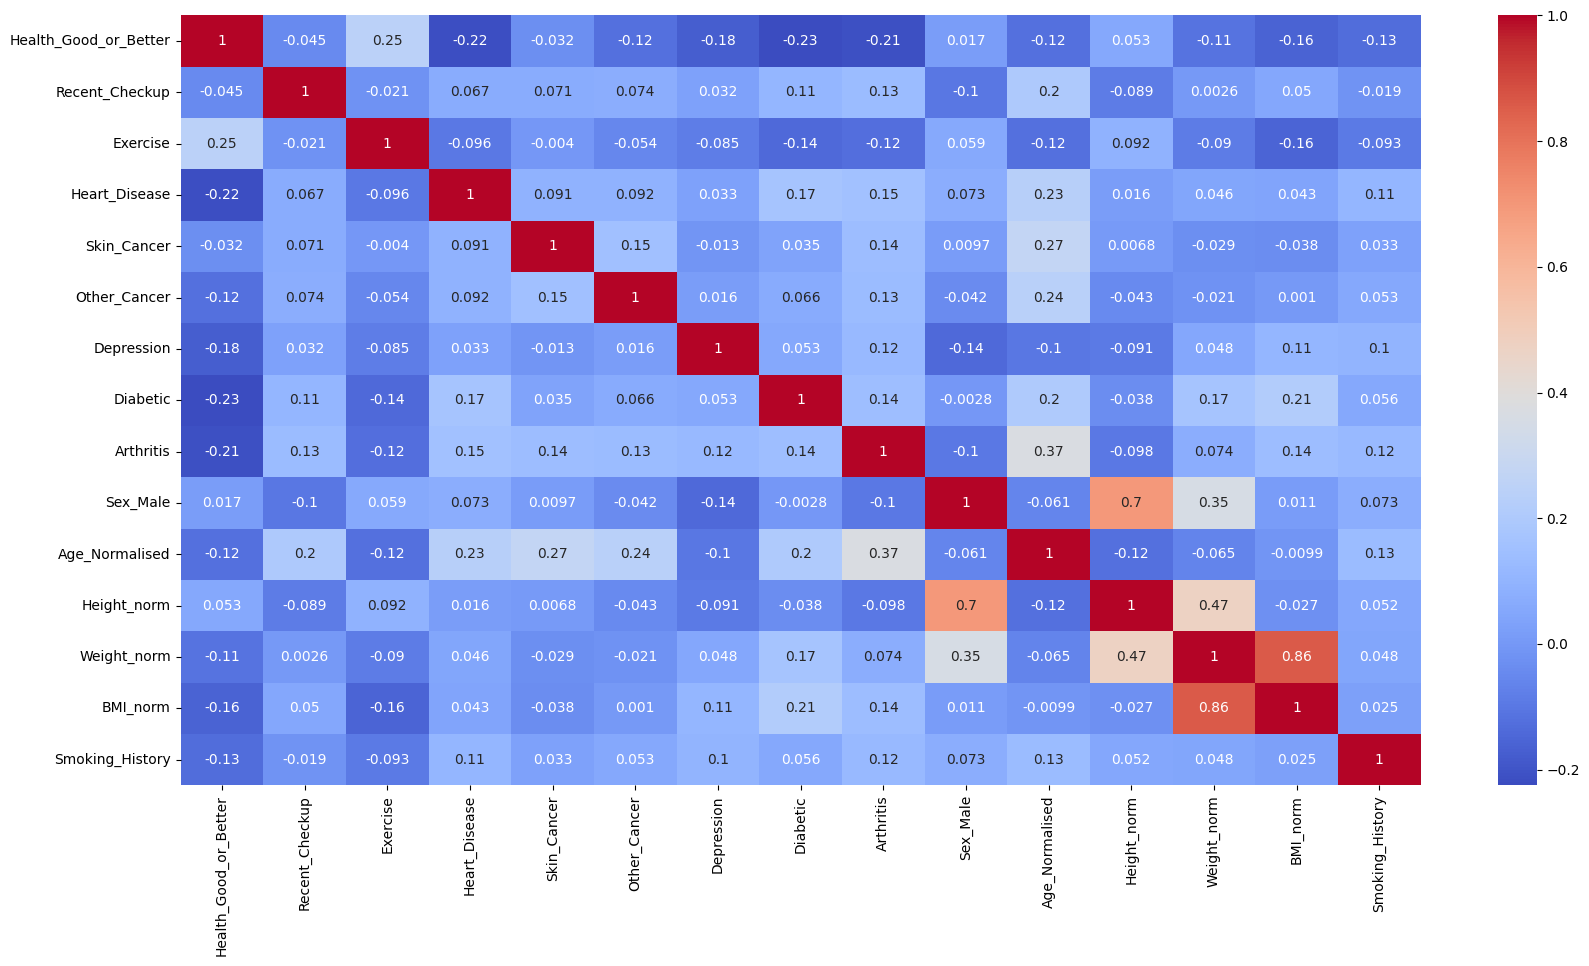

In [101]:
corr = data.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(
    corr, annot=True, cmap="coolwarm"
)  # We use sns to easily get the actual values of each correlation in the figure
plt.savefig("../Graphs/dataset/correlation_matrix.png")
plt.show()

The correlation matrix shows us some interesting relations. At first, we can see that weight and height are correlated, which makes sense. BMI and weight are correlated, which also makes sense. We can see that people that report having some medical condition, such as arthritis, diabetes or even heart disease correlate to having a worse perceived health. It is surprising that recent checkups do not correlate much with heart disease. The frequency of the checkups does not say much about the health of the person. From the correlation matrix alone it is hard to say much about finding any predictors for heart disease.


### Plots of healthy people against people with heart disease <a id='plots-healthy-unhealthy'></a>

We will plot the histograms and inspect whether there is a big difference between the data for healthy people and people with heart disease.


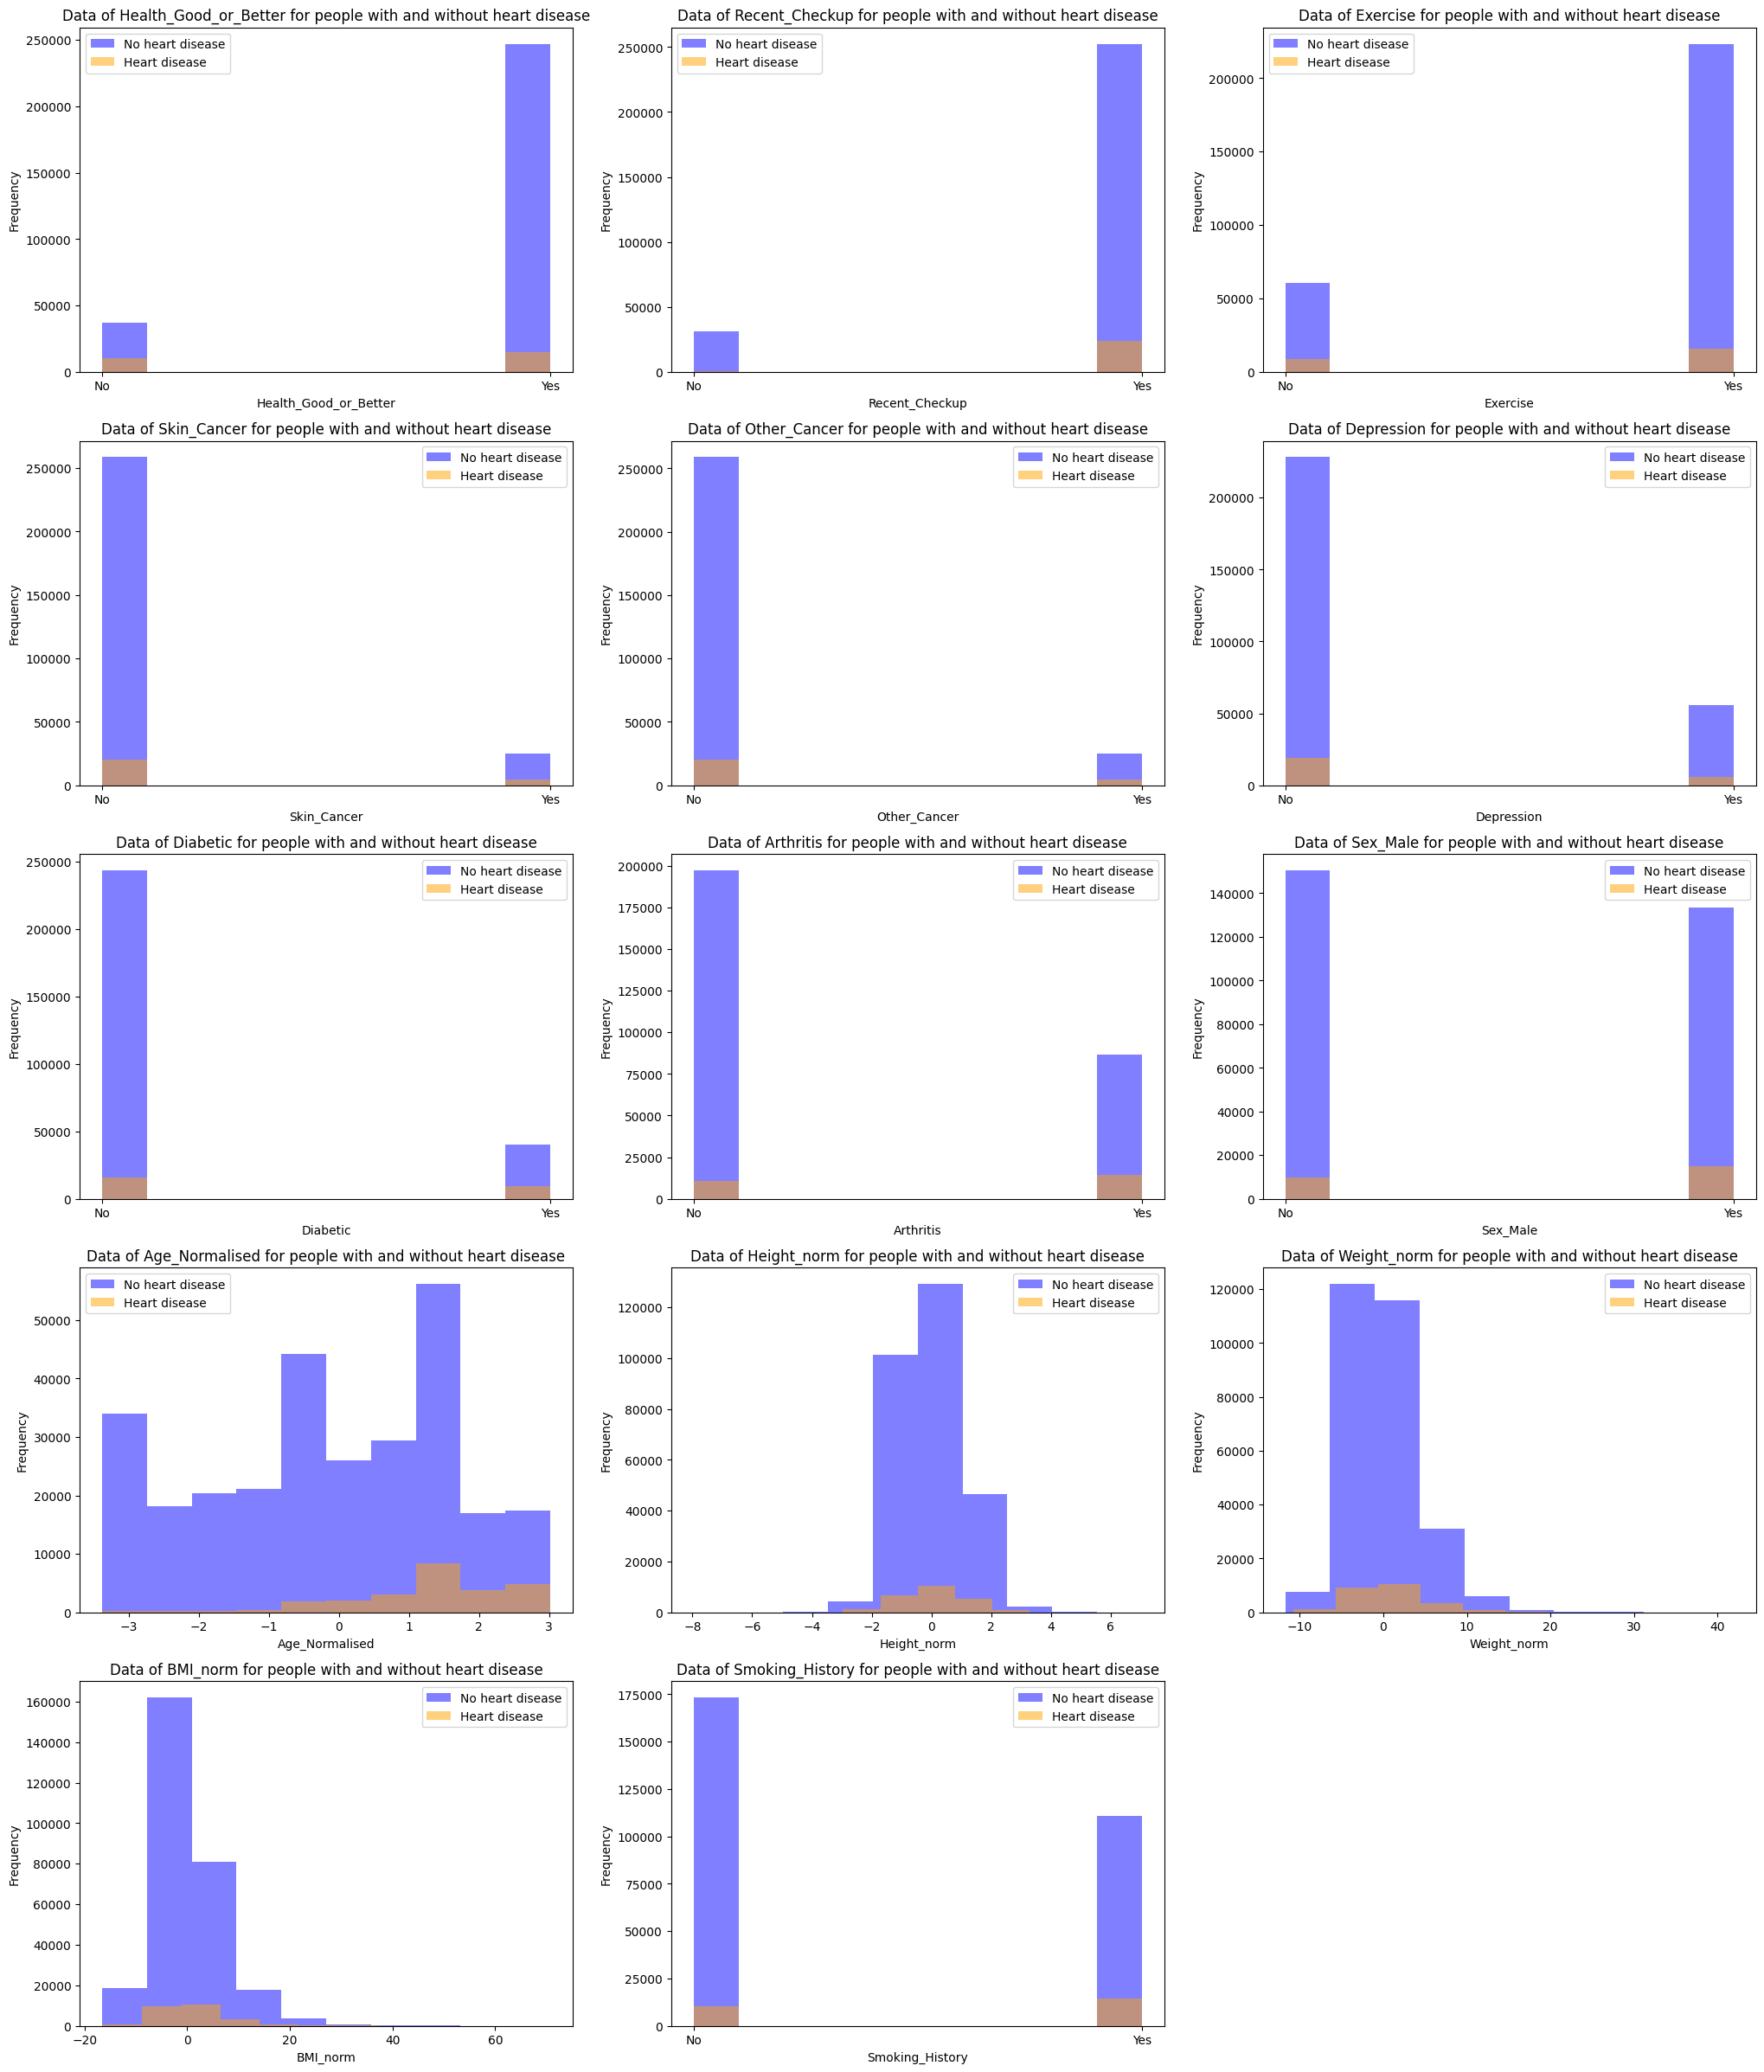

In [102]:
no_heart_disease = data.loc[data["Heart_Disease"] == 0]
heart_disease = data.loc[data["Heart_Disease"] == 1]

no_heart_disease_y = no_heart_disease["Heart_Disease"]  # y vector
heart_disease_y = heart_disease["Heart_Disease"]  # y vector

no_heart_disease = no_heart_disease.drop(columns=["Heart_Disease"])
heart_disease = heart_disease.drop(columns=["Heart_Disease"])

fig, axs = plt.subplots(5, 3, figsize=(25, 30))

c = 0
for i in range(14):
    plt.subplot(5, 3, i + 1)
    plt.hist(
        no_heart_disease[no_heart_disease.columns[i]],
        label="No heart disease",
        alpha=0.5,
        color="b",
    )
    plt.hist(
        heart_disease[heart_disease.columns[i]],
        label="Heart disease",
        alpha=0.5,
        color="orange",
    )
    plt.xlabel(no_heart_disease.columns[i])
    plt.ylabel("Frequency")
    plt.title(
        f"Data of {no_heart_disease.columns[i]} for people with and without heart disease"
    )

    unique_vals = no_heart_disease[no_heart_disease.columns[i]].unique()
    if len(unique_vals) == 2 and all([x in [0, 1] for x in unique_vals]):
        plt.xticks([0, 1], ["No", "Yes"])

    plt.legend()
    c += 1

fig.delaxes(axs[-1, -1])  # remove the empty subplot
plt.show()

The graphs do not immediately show a clear difference between the two groups, so we can not conclude much about this.


## Running a basic logistic regression model

<a id='logistic-regression'></a>

### Creating training and testing data

<a id='testing-training-data'></a>

We split the data into training and testing sets. We use 75% of the data for training and 25% for testing.


In [103]:
# splitting into X and Y and adding a constant
Y = data["Heart_Disease"]
X = data.drop(columns="Heart_Disease")
X_intercept = sm.add_constant(X)

# recombining XY
column_names = ["constant"]
for i in data.columns:
    column_names.append(i)

XY_constant = pd.DataFrame(
    np.hstack((np.array(Y)[:, np.newaxis], X_intercept)), columns=column_names
)

In [104]:
# splitting into test and train set (25:75)
num_samples = 0.25 * len(XY_constant)
row_ids = list(range(XY_constant.shape[0]))

# randomly select 25% of the row ids
selected_row_ids = random.sample(row_ids, round(num_samples))

# subset to create train and test
data_test = XY_constant.iloc[XY_constant.index.isin(selected_row_ids)]
data_train = XY_constant.iloc[~XY_constant.index.isin(selected_row_ids)]

In [105]:
Y_train = data_train["Heart_Disease"]
Y_test = data_test["Heart_Disease"]
X_train = data_train.drop(columns="Heart_Disease")
X_test = data_test.drop(columns="Heart_Disease")

### Running model

<a id='running-model'></a>

Now we can run a logistic regression model:


In [106]:
model = sm.Logit(Y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.487905
         Iterations 6


In [107]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Heart_Disease   No. Observations:               231640
Model:                          Logit   Df Residuals:                   231625
Method:                           MLE   Df Model:                           14
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                 0.08529
Time:                        17:45:18   Log-Likelihood:            -1.1302e+05
converged:                       True   LL-Null:                   -1.2356e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
constant                 -0.1474      0.018     -8.163      0.000      -0.183      -0.112
Health_Good_or_Better     0.5049      0.024     21.346      0.000       0.459       0.551
Recent_Checkup            1.0243      0.013     76.302      0.000       0.998       1.051
Exercise                  0.2069      0.018     11.290      0.000       0.171       0.243
Skin_Cancer               0.2193      0.018     12.050      0.000       0.184       0.255
Other_Cancer             -0.0343      0.017     -2.013      0.044      -0.068      -0.001
Depression               -0.1934      0.013    -14.679      0.000      -0.219      -0.168
Diabetic                 -0.2876      0.014    -21.040      0.000      -0.314      -0.261
Arthritis                -0.0954      0.012     -8.007      0.000      -0.119      -0.072
Sex_Male                  0.0460      0.015      3.070      0.002       0.017       0.075
Age_Normalised           -0.1345      0.004    -37.138      0.000      -0.142      -0.127
Height_norm               0.1920      0.021      9.001      0.000       0.150       0.234
Weight_norm              -0.0232      0.010     -2.367      0.018      -0.042      -0.004
BMI_norm                 -0.0269      0.006     -4.787      0.000      -0.038      -0.016
Smoking_History          -0.2783      0.011    -25.829      0.000      -0.299      -0.257
=========================================================================================
"""

In [108]:
# generate predictions
predictions = model.predict(X_test)
# transfrom predictions to binary
prediction_binary = (predictions > 0.5).astype(int)

In [109]:
# compute accuracy score
accuracy = accuracy_score(y_true=Y_test, y_pred=prediction_binary)
print(accuracy)

0.7815681094102106


### Simulating the coefficients <a id='simulating-coefficients'></a>


In [110]:
# extract the coefficients and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()
# number of simulations
n_simulations = 10000

# simulate coefficients
simulated_betas = multivariate_normal.rvs(
    mean=beta_mean, cov=beta_cov, size=n_simulations
)

simulated_betas_odds = np.exp(simulated_betas)

# derive probabilities from odds
simulated_betas_p = simulated_betas_odds / (simulated_betas_odds + 1)

# calculate mean p value per variable
# Transpose the list of lists to group by variable (columns)
variables = zip(*simulated_betas_p)  # Groups all simulations for each variable

# Calculate mean p-values for each variable
p_means = [sum(variable) / len(variable) for variable in variables]

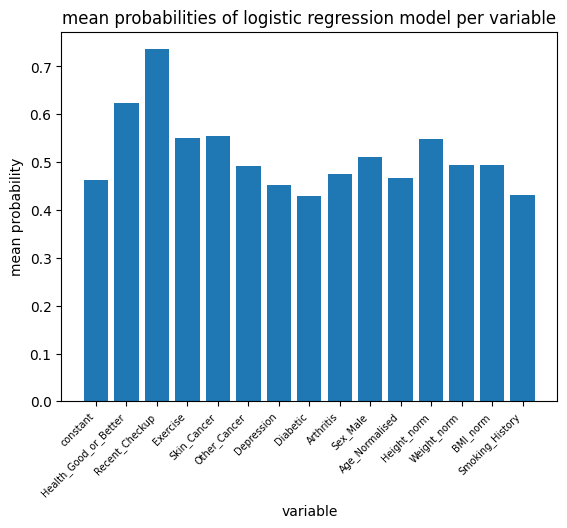

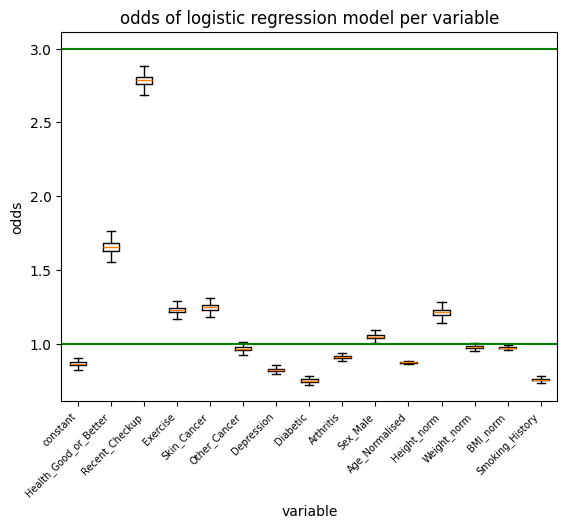

In [115]:
# plot mean p values
x_labels = X_train.columns.tolist()
plt.bar(x_labels, p_means)
plt.xticks(ticks = np.arange(0, 15, 1), labels = x_labels, rotation=45, ha='right', size = 7) 
plt.title('mean probabilities of logistic regression model per variable')
plt.xlabel('variable')
plt.ylabel('mean probability')
plt.savefig(f'{paths[0]}coefficient_probabilities.png', bbox_inches='tight')
plt.show()

# boxplot of p values
plt.boxplot(simulated_betas_odds, showfliers = False)
plt.xticks(ticks = np.arange(1, 16, 1), labels = x_labels, rotation=45, ha='right', size = 7)  
plt.axhline(y = 1, color = 'g')
plt.axhline(y = 3, color = 'g')
plt.title('odds of logistic regression model per variable')
plt.xlabel('variable')
plt.ylabel('odds')
plt.savefig(f'{paths[0]}odds_ratios.png', bbox_inches='tight')
plt.show()

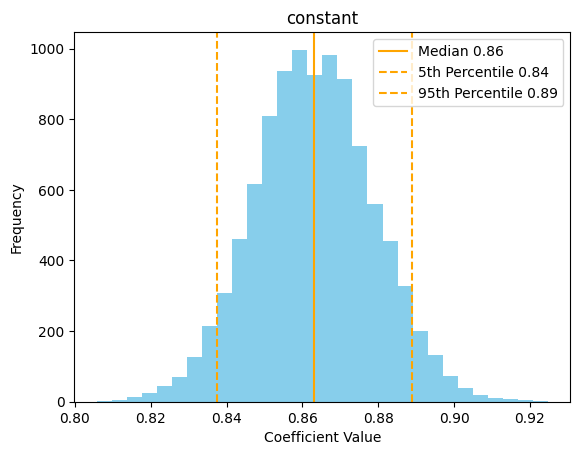

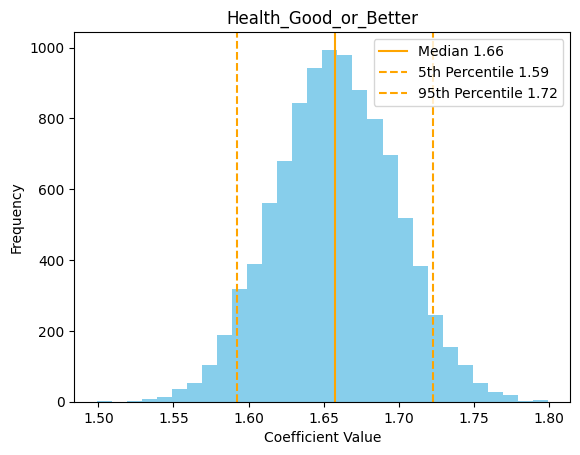

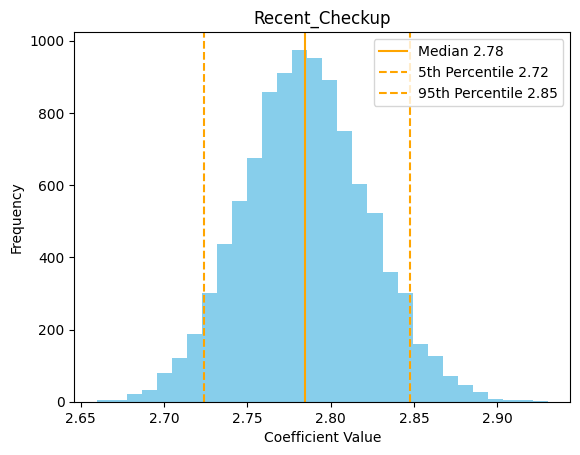

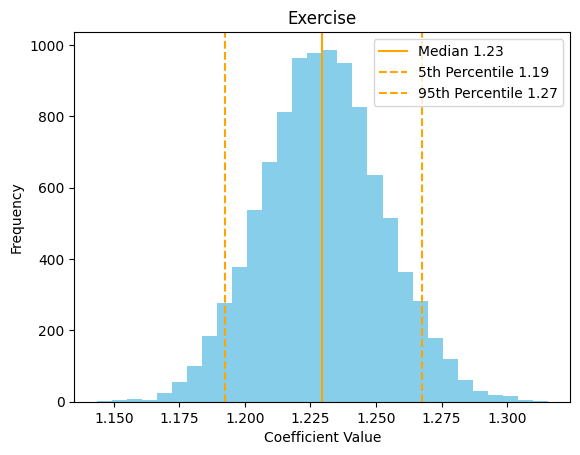

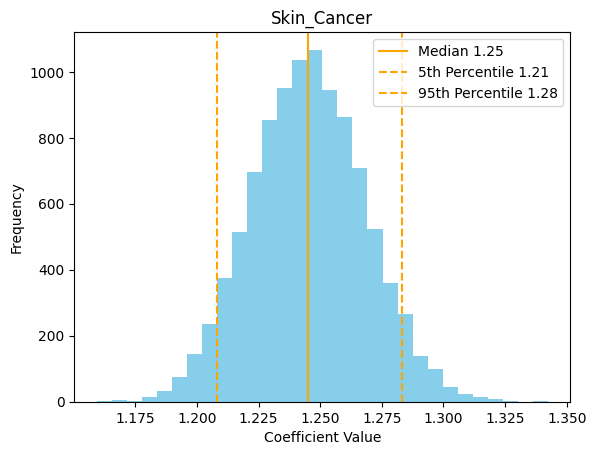

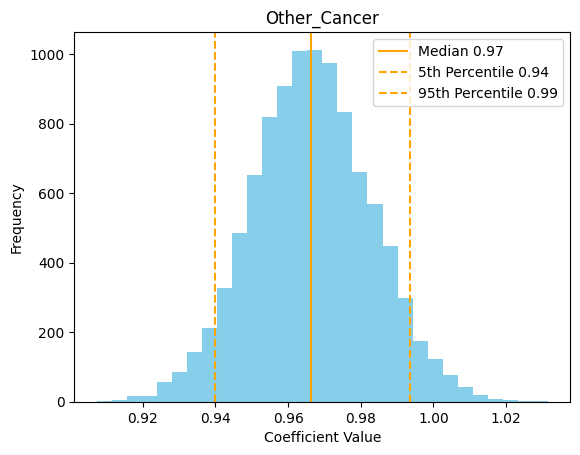

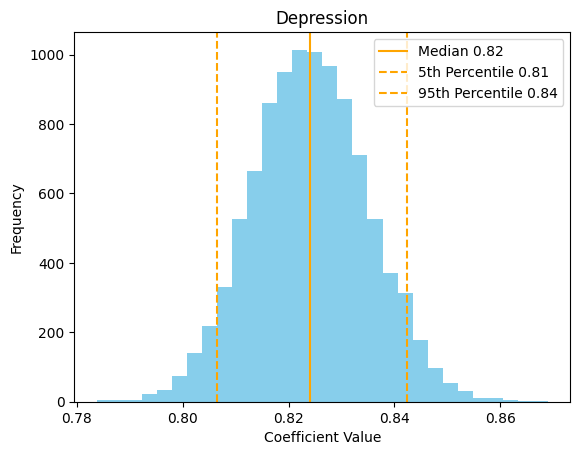

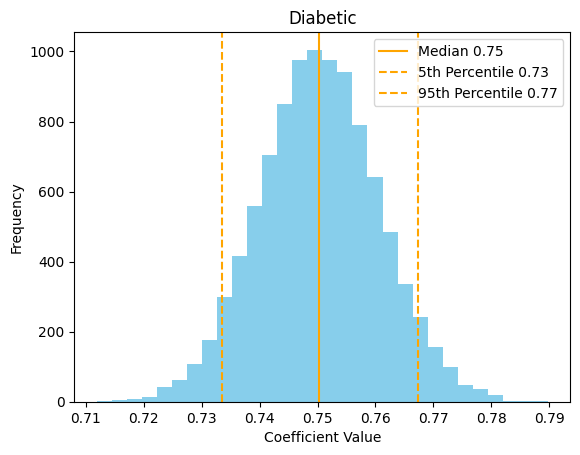

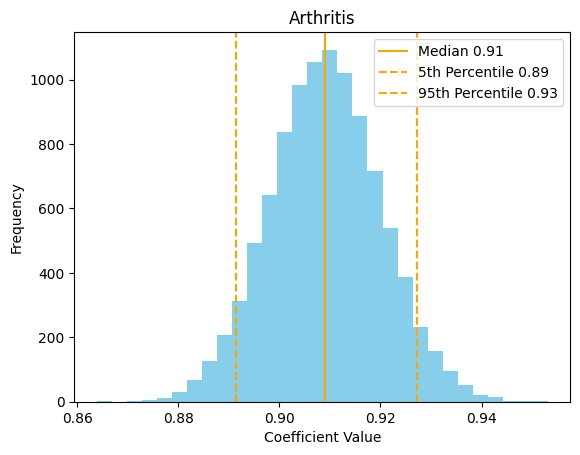

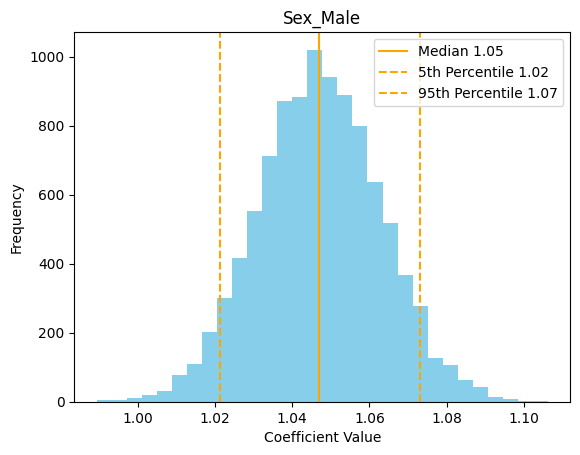

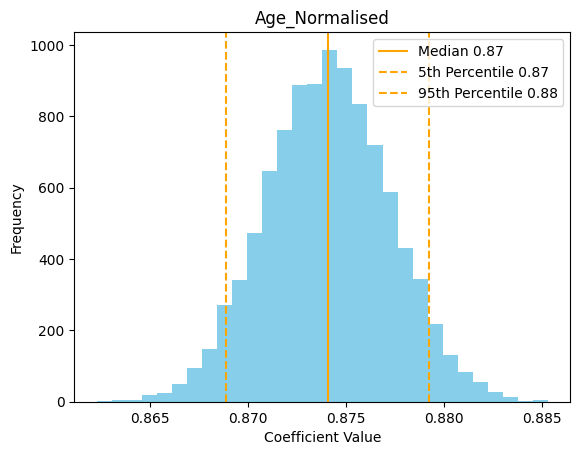

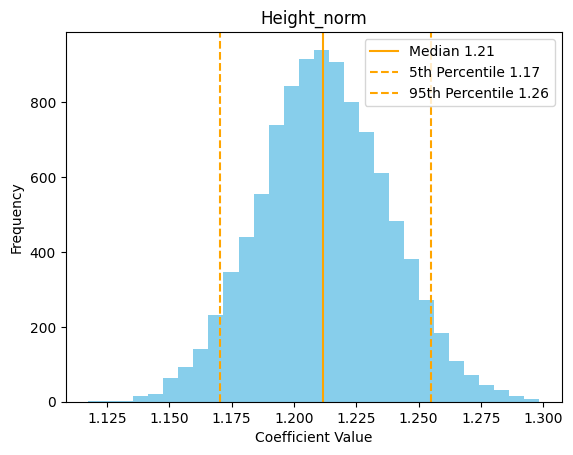

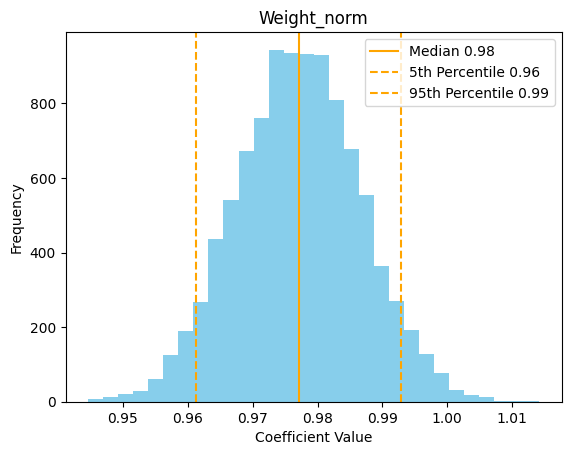

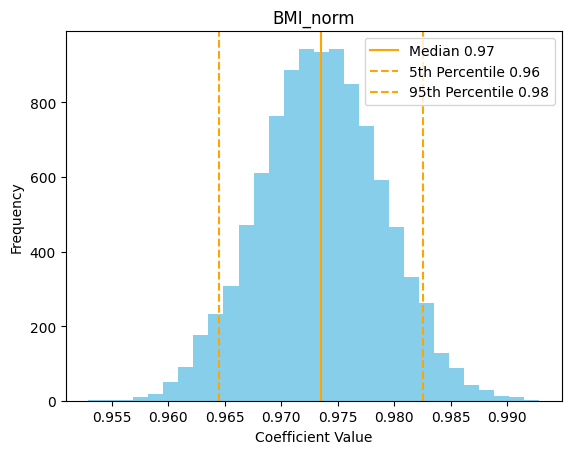

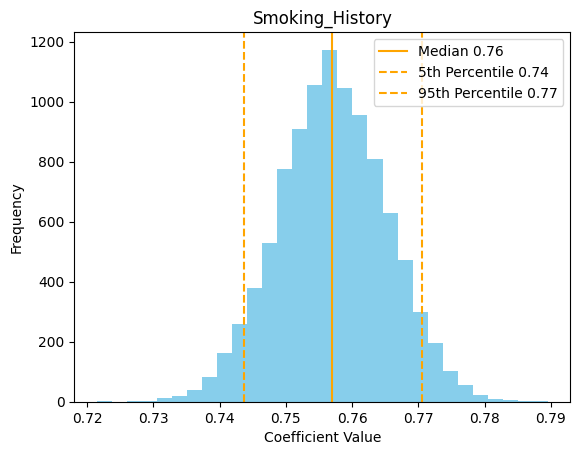

In [112]:
# plot the distribution of each coefficient to assess and interpret them
for name, i in zip(X_test.columns, range(simulated_betas_odds.shape[1])):
    plt.figure()
    plt.hist(simulated_betas_odds[:, i], bins=30, color="skyblue")
    plt.axvline(
        x=np.median(simulated_betas_odds, axis=0)[i],
        color="orange",
        label=f"Median {np.median(simulated_betas_odds, axis = 0)[i]:.2f}",
    )
    plt.axvline(
        x=np.percentile(simulated_betas_odds, 5, axis=0)[i],
        color="orange",
        label=f"5th Percentile {np.percentile(simulated_betas_odds, 5, axis = 0)[i]:.2f}",
        linestyle="--",
    )
    plt.axvline(
        x=np.percentile(simulated_betas_odds, 95, axis=0)[i],
        color="orange",
        label=f"95th Percentile {np.percentile(simulated_betas_odds, 95, axis = 0)[i]:.2f}",
        linestyle="--",
    )
    plt.title(f"{name}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

### Interpretation of Coefficients

- The constant represents the baseline odds of having heart disease. This means that for a person with a poor or fair self perceived health status, who has not had a checkup in the past two years, who does not exercise, who does not have skin cancer or any other cancer, who does not have depression, who is not diabetic, who does not have arthritis, who is female, who is of average age, height, weight, and BMI, and who does not have a smoking history, the odds of having heart disease are 0.86 (0.83, 0.88). This indicates that the average person that falls into this category has a smaller chance of having heart disease than the chance of not having heart disease.

- For all the other coefficients, the average odds essentially capture the percentage change of the odds of having heart disease if a variable is increased by one point. The percentage change can be derived by taking the difference of the coefficient odds ratios compared to 1. For instance, an individual as described above who is a male, would have a roughly 5% increased odds of having heart disease. Furthermore, if the value of 1 falls in the confidence intervals of a coefficient, we can deduct that this coefficient does not have a statistically significant effect on the dependent variable.

## Principal Component Analysis

<a id='pca'></a>


Our original dataset has 19 variables, which would most likely be too much for a logistic regression model. We want to decrease this amount and ensure that the variables are not correlated in a way to make our model more accurate. To do this, we can use PCA. PCA finds 'principal components', which are the directions that explain maximal variance in the data in some direction. We can see it as a 'summary' of the data.


### Finding amount of components needed

<a id='amount-components'></a>

We want to retain 95% of the variance in the data, so we will use a trial-and error to find the amount of components we need.


In [113]:
X = data.drop(columns="Heart_Disease")

# Percentage of variance that we want to keep, should be between 0 and 0.99
percentage = 0.95
components = 0

# simulate a do-while loop
while True:

    pca = PCA(n_components=components)
    pca_data = pca.fit_transform(X)

    # if this is smaller than 0 we have kept at least percentage amount
    # of variance in the PCA.
    if percentage - sum(pca.explained_variance_ratio_) < 0:
        break

    components += 1

print(
    f"Number of components to use to keep {percentage * 100:.0f}% of the variance: {components}"
)

Number of components to use to keep 95% of the variance: 3


The same procedure, but now in a plot:


In [114]:
# Percentage of variance that we want to keep, should be between 0 and 0.99
percentage = 0.95
components = 0

# simulate a do-while loop
components = 0
ys = []
while True:

    pca = PCA(n_components=components)
    pca.fit_transform(X)

    # if this is smaller than 0 we have kept at least percentage amount
    # of variance in the PCA.
    ys.append(sum(pca.explained_variance_ratio_))
    if percentage - sum(pca.explained_variance_ratio_) < 0:
        break

    components += 1

print(
    f"Number of components to use to keep {percentage * 100:.0f}% of the variance: {components}"
)
plt.scatter(range(len(ys)), ys, marker="x", color="red")
plt.plot(range(len(ys)), ys, linestyle="--")
plt.xticks(range(len(ys)))
plt.axhline(
    percentage, color="green", linestyle="dashdot", label="Desired kept variance"
)
plt.title(
    f"Number of components to use to keep {percentage * 100:.0f}% of the variance: {components}"
)
plt.xlabel("Number of components")
plt.ylabel("Kept variance (%)")
plt.legend()
plt.savefig(f"{paths[0]}PCA_optimisation.png", dpi=300)
plt.show()

KeyboardInterrupt: 

From this we know that we need 3 components to retain 95% of the variance in the data.


In [ ]:
data.columns

In [ ]:
loadings = pca.components_.T
loadings

The loading matrix tells us the weight each variable has in each component. This tell us the following:

The first principal component is mostly explained by the BMI, weight and height of the person.

The second principal component is mostly explained by the height and weight of the person.

The third component is mostly explained by the age of the person.

In conclusion we can say that the first and second component is mostly explained by the physical characteristics of a person, and the third component is explained by the age of the person.

From literature we know that age is important, but the height of a person is not necessarily important for cardiovascular disease. This could be a sign that PCA loses some valuable information in the data. It could be better to hand-pick the important variables.


## Cross Validation
<a id='crossVal'></a>

### Implement Cross-Validation (k-fold) for RQ_2:

<a id='comparing-models'></a>

- $\text{RQ}_2$: Does a logistic regression model based on PCA-generated components predict with higher accuracy than a logistic regression model fit on the 'clean' data?

We had the following null hypothesis for this question:

- $H_0$: A logistic regression model using PCA-generated components does not achieve significantly higher accuracy compared to a logistic regression model using the original 'clean' data.

To test this hypothesis, and to find an answer to the research question, we performed k-fold cross validation on both models, and plotted the distribution of their respective accuracy scores, along with their respective means and 95% confidence intervals.


In [ ]:
# selecting the target variable
y = XY_constant["Heart_Disease"]

# define K for cross validation
K = 500

# setup the k-fold cross-validation
kf = KFold(n_splits=K, shuffle=True)

# dictionary for the model names and features
pca_df = pd.DataFrame(pca_data)
# models = {'Base model': XY_constant.drop(columns='Heart_Disease'), 'PCA model': pca_df, 'Constant model': XY_constant['constant']}
models = {"Base model": XY_constant.drop(columns="Heart_Disease"), "PCA model": pca_df}

# initialize a dictionary to store accuracy data and aic data
acc_dict = {key: [] for key in models.keys()}
aic_dict = {key: [] for key in models.keys()}

for key, df in models.items():

    for train_index, test_index in kf.split(XY_constant):

        # Split into train and test according to the folds
        X_train, X_test = df.iloc[train_index], df.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # For each fold split, fit the model
        model = sm.Logit(y_train, X_train).fit()

        # Predict probabilities
        y_pred_prob = model.predict(X_test)

        # convert probabilities to binary predictions
        y_pred_binary = (y_pred_prob > 0.5).astype(int)

        acc_dict[key].append(accuracy_score(y_true=y_test, y_pred=y_pred_binary))
        aic_dict[key].append(model.aic)

In [ ]:
# calculate average aic of all models
average_aic = {key: sum(aic) / len(aic) for key, aic in aic_dict.items()}

colors = ["palegreen", "paleturquoise"]
linecolors = ["lightcoral", "goldenrod"]

# plot the histogram of the PCA accuracies and overlay the baseline model's mean
for i, key in zip(range(len(acc_dict.keys())), acc_dict.keys()):
    plt.hist(acc_dict[key], bins=25, color=colors[i], label=f"{key} accuracies")
    plt.axvline(np.mean(acc_dict[key]), color=linecolors[i], linestyle="--")
    plt.axvline(np.percentile(acc_dict[key], 2.5), color=linecolors[i], linestyle=":")
    plt.axvline(np.percentile(acc_dict[key], 97.5), color=linecolors[i], linestyle=":")

# plt.hist(acc_dict['Constant model'], bins=30, color='firebrick', alpha=0.3, label='Constant model')
plt.title("Distribution of k-fold computed accuracies")
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.legend()
plt.savefig(f"{paths[0]}CrossVal_RQ2.png", dpi=300)
plt.show()

# print average aic scores
print("average aic:", average_aic)

- Looking at the distribution of accuracy scores, we can quite clearly see that a logistic regression model using PCA-generated components does not achieve significantly higher accuracy compared to a logistic regression model using the original 'clean' data. As such, we _fail to reject_ our null hypothesis. The answer to our research question becomes:
  - No, a logistic regression model based on PCA-generated components does not predict with higher accuracy than a logistic regression model fit on the ‘clean’ data.


However, this is not all we can interpret from these distributions:

- We can see that the model fit on all variables centres around a very high accuracy score of _roughly_ 78%. Since we trained the model on all variables, this accuracy could very much be the result of overfitting.
- As such, we should run another cross validation, this time for each possible combination of variables in the given data.
  - This way, we can find out which combinations of variables yield the best results.
    - Finding smaller sets of variables that yield good results can be considered better, as they are less likely to overfit.
  - We can also learn more about which variables are the most predictive.
- We constructed the following research question to guide this process:

  - $RQ_3$: Can we extract how many variables - and which - contribute to a high model accuracy?

- However, such an approach requires extensive computational power, and was unfortunately not feasible given the project timeline.
- Instead, we selected five variables based on literature, which have been found to be key indicators of heart disease:
  - Age
  - Gender
  - Smoking
  - Exercise
  - Diabetes
- We then performed cross validation on five different models, adding one variable - in the same order as listed above - each model.
- The results are listed below.


### Implementing K-fold for select variables and plotting the distribution of their accuracies
<a id='select-variables'></a>

In [ ]:
# define K for cross validation
K = 100

# setup the k-fold cross-validation
kf = KFold(n_splits=K, shuffle=True)

# dictionary for the model names and features
models = {
    "Age": XY_constant[["constant", "Age_Normalised"]],
    "Age+Gender": XY_constant[["constant", "Age_Normalised", "Sex_Male"]],
    "Age+Gender+Smoking": XY_constant[
        ["constant", "Age_Normalised", "Sex_Male", "Smoking_History"]
    ],
    "Age+Gender+Smoking+Exercise": XY_constant[
        ["constant", "Age_Normalised", "Sex_Male", "Smoking_History", "Exercise"]
    ],
    "Age+Gender+Smoking+Exercise+Diabetic": XY_constant[
        [
            "constant",
            "Age_Normalised",
            "Sex_Male",
            "Smoking_History",
            "Exercise",
            "Diabetic",
        ]
    ],
}

# initialize a dictionary to store accuracy data and aic data
acc_dict = {key: [] for key in models.keys()}
aic_dict = {key: [] for key in models.keys()}

for key, df in models.items():

    for train_index, test_index in kf.split(XY_constant):

        # Split into train and test according to the folds
        X_train, X_test = df.iloc[train_index], df.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # For each fold split, fit the model
        model = sm.Logit(y_train, X_train).fit()

        # Predict probabilities
        y_pred_prob = model.predict(X_test)

        # convert probabilities to binary predictions
        y_pred_binary = (y_pred_prob > 0.5).astype(int)

        acc_dict[key].append(accuracy_score(y_true=y_test, y_pred=y_pred_binary))
        aic_dict[key].append(model.aic)

In [ ]:
# turn our data into an array like structure or DataFrame
accuracies_for_box = pd.DataFrame(acc_dict)

plt.boxplot(accuracies_for_box, showfliers=False)
plt.ylim(0, 1)
plt.xticks([1, 2, 3, 4, 5], labels=accuracies_for_box.columns, rotation=45)
for i in range(len(accuracies_for_box.columns)):
    plt.axvline(i + 1, color="grey", alpha=0.3, linestyle="--")
plt.ylabel("Accuracy Score")
plt.title("Boxplot of accuracy scores for models with select variables")
plt.savefig(f"{paths[0]}Select_Variable_CrossVal_A.png", bbox_inches="tight")
plt.show()

We plotted the resulting accuracy distributions for each model in a boxplot, as can be seen above. We observe the following:

- Age alone yields accuracies around 50-55%, which can be considered relatively low compared to what we've seen before.
- Through the addition of variables, the accuracy gradually increases.
- The model fit on the variables `age`, `gender`, `smoking`, and `exercise` yields the highest overall accuracy, getting close to 80%.


However, this alone does not tell us enough. As we said before, in an ideal situation we would test each possible combination of variables. The next best thing we can do now, is perform this same analysis, but with the variables reversed. Then, we could determine whether the climbing accuracy occurs due to the addition of more variables, or if it occurs due to the specific variables which are added.


### Implementing K-fold for reversed selection of variables and plotting the distribution of their accuracies
<a id='reversed-selection'></a>

In [ ]:
# define K for cross validation
K = 100

# setup the k-fold cross-validation
kf = KFold(n_splits=K, shuffle=True)

# dictionary for the model names and features
models = {
    "Diabetic": XY_constant[["constant", "Diabetic"]],
    "Diabetic+Exercise": XY_constant[["constant", "Diabetic", "Exercise"]],
    "Diabetic+Exercise+Smoking": XY_constant[
        ["constant", "Diabetic", "Exercise", "Smoking_History"]
    ],
    "Diabetic+Exercise+Smoking+Gender": XY_constant[
        ["constant", "Diabetic", "Exercise", "Smoking_History", "Sex_Male"]
    ],
    "Diabetic+Exercise+Smoking+Gender+Age": XY_constant[
        [
            "constant",
            "Diabetic",
            "Exercise",
            "Smoking_History",
            "Sex_Male",
            "Age_Normalised",
        ]
    ],
}

# initialize a dictionary to store accuracy data and aic data
acc_dict = {key: [] for key in models.keys()}
aic_dict = {key: [] for key in models.keys()}

for key, df in models.items():

    for train_index, test_index in kf.split(XY_constant):

        # Split into train and test according to the folds
        X_train, X_test = df.iloc[train_index], df.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # For each fold split, fit the model
        model = sm.Logit(y_train, X_train).fit()

        # Predict probabilities
        y_pred_prob = model.predict(X_test)

        # convert probabilities to binary predictions
        y_pred_binary = (y_pred_prob > 0.5).astype(int)

        acc_dict[key].append(accuracy_score(y_true=y_test, y_pred=y_pred_binary))
        aic_dict[key].append(model.aic)

In [ ]:
# turn our data into an array like structure or DataFrame
accuracies_for_box = pd.DataFrame(acc_dict)

plt.boxplot(accuracies_for_box, showfliers=False)
plt.ylim(0, 1)
plt.xticks(
    [i + 1 for i in range(len(accuracies_for_box.columns))],
    labels=accuracies_for_box.columns,
    rotation=45,
)
for i in range(len(accuracies_for_box.columns)):
    plt.axvline(i + 1, color="grey", alpha=0.3, linestyle="--")
plt.ylabel("Accuracy Score")
plt.title("Boxplot of accuracy scores for models with select variables")
plt.savefig(f"{paths[0]}Select_Variable_CrossVal_B.png", bbox_inches="tight")
plt.show()

Now that we have the results for the reversed order, we can spot some interesting things.

- `Diabetes` does not appear to be a strong predictor, despite its frequent academic mentioning as one.
- Despite `diabetes` not being a strong predictor, when paired with `exercise`, the model accuracy jumps to roughly 70-something percent.
- As more variables are added, the accuracy does not change by much.
- This indicates that `exercise` may be the variable that is doing the heavy lifting in terms of predictability.


### Following these results, we perform one final cross validation. This time, only using the `exercise` variable. The results can be seen below.
<a id='exercise-implementation'></a>

In [ ]:
# define K for cross validation
K = 200

# setup the k-fold cross-validation
kf = KFold(n_splits=K, shuffle=True)

# dictionary for the model names and features
models = {
    "Exercise": XY_constant[["constant", "Exercise"]],
}

# initialize a dictionary to store accuracy data and aic data
acc_dict = {key: [] for key in models.keys()}
aic_dict = {key: [] for key in models.keys()}

for key, df in models.items():

    for train_index, test_index in kf.split(XY_constant):

        # Split into train and test according to the folds
        X_train, X_test = df.iloc[train_index], df.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # For each fold split, fit the model
        model = sm.Logit(y_train, X_train).fit()

        # Predict probabilities
        y_pred_prob = model.predict(X_test)

        # convert probabilities to binary predictions
        y_pred_binary = (y_pred_prob > 0.5).astype(int)

        acc_dict[key].append(accuracy_score(y_true=y_test, y_pred=y_pred_binary))
        aic_dict[key].append(model.aic)

In [ ]:
# turn our data into an array like structure or DataFrame
accuracies_for_box = pd.DataFrame(acc_dict)

plt.boxplot(accuracies_for_box, showfliers=False)
plt.ylim(0, 1)
plt.xticks([1], labels=accuracies_for_box.columns, rotation=45)
plt.axvline(1, color="grey", alpha=0.3, linestyle="--")
plt.ylabel("Accuracy Score")
plt.title("Boxplot of accuracy scores for models with select variables")
plt.savefig(f"{paths[0]}Exercise_CrossVal.png", bbox_inches="tight")
plt.show()

We can see that if we build a model using only an intercept and the `exercise` feature, we yield an accuracy score of roughly 70%. This tells us that `exercise` is a very predictive feature - as we suspected earlier. However, we must be weary of how we interpret this. Firstly, as a standalone analysis, this does not tell us anything about the direction of the relationship between exercise and heart disease. Luckily, we looked into this earlier. We also need to consider the fact that there may be some autocorrelation or codependence which causes exercise to be so predictable.
